<a href="https://colab.research.google.com/github/anjali88/Data-Science/blob/master/TradingHFT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accurately predicting the stock markets is a complex task as there are millions of events and pre-conditions for a particilar stock to move in a particular direction. So we need to be able to capture as many of these pre-conditions are possible. We also need make several important assumptions: 1) markets are not 100% random, 2) history repeats, 3) markets follow people's rational behavior, and 4) the markets are 'perfect'. 

We will try to predict the price movements of 100 High Frequency Trading (HFT) companies. For the purpose, we will use daily closing price from Feb 2nd, 2018 to August 29th, 2018 (70% for training purposes and 30% for validation purposes). 


# Dataset
We need to understand what affects whether, stock price will move up or down. It is what people as a whole think. Hence, we need to incorporate as much information (depicting the stock from different aspects and angles) as possible. (We will use daily data - 47716 days to train the various algorithms (70% of the data we have) and predict the next  20451 days (test data). Then we will compare the predicted results with a test (hold-out) data. Each type of data (we will refer to it as feature) is explained in greater detail in later sections, but, as a high level overview, the features we will use are:

> 1. Correlated assets - All the 100 companies, obviously doesn't 'live' in an isolated world - it depends on, and interacts with, many external factors, including its competitors, clients, the global economy, the geo-political situation, fiscal and monetary policies, access to capital, etc. The details are listed later.

> 2. Technical indicators - a lot of investors follow technical indicators. We will include the most popular indicators as independent features. Among them - 7 and 21 days moving average, exponential moving average, momentum, Bollinger bands, MACD.

> 3. Fundamental analysis - A very important feature indicating whether a stock might move up or down. There are two features that can be used in fundamental analysis: 
     1) Analysing the company performance using 10-K and 10-Q reports, analysing ROE and P/E, etc (we will not use this)
     2) News - potentially news can indicate upcoming events that can potentially move the stock in certain direction. We will read all daily news for Anglo-American Plc and extract whether the total sentiment about the company on that day is positive, neutral, or negative (as a score from 0 to 1). As many investors closely read the news and make investment decisions based (partially of course) on news, there is a somewhat high chance that if, say, the news for companies today are extremely positive the stock will surge tomorrow. One crucial point, we will perform feature importance (meaning how indicative it is for the movement of companies) on absolutely every feature (including this one) later on and decide whether we will use it. For the purpose of creating accurate sentiment prediction we will use Neural Language Processing (NLP). We will use BERT - Google's recently announced NLP approach for transfer learning for sentiment classification stock news sentiment extraction.

> 4. Fourier transforms - Along with the daily closing price, we will create Fourier transforms in order to generalize several long- and short-term trends. Using these transforms we will eliminate a lot of noise (random walks) and create approximations of the real stock movement. Having trend approximations can help the LSTM network pick it's prediction trends more accurately.

> 5. Autoregressive Integrated Moving Average (ARIMA) - This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). We will add it and see if it comes off as an important predictive feature.

> 6. Stacked autoencoders - most of the aforementioned features (fundamental analysis, technical analysis, etc) were found by people after decades of research. But maybe we have missed something. Maybe there are hidden correlations that people cannot comprehend due to the enormous amount of data points, events, assets, charts, etc. With stacked autoencoders (type of neural networks) we can use the power of computers and probably find new types of features that affect stock movements. Even though we will not be able to understand these features in human language, we will use them in the GAN.

> 7. Deep Unsupervised learning for anomaly detection in options pricing

> 8. Perform statistical checks for the 'quality' of the data. If the data we create if flawed, then no matter how sophisticated our algorithms are, the results will not be positive. The checks include making sure the data does not suffer from heteroskedasticity, multicollinearity, or serial correlation.
Create feature importance. If a feature (e.g. another stock or a technical indicator) has no explanatory power to the stock we want to predict, then there no need for us to use it in the training of the neural nets. We will using XGBoost (eXtreme Gradient Boosting), a type of boosted tree regression algorithms.

> 9. Last step of our data preparation, we will create Eigen portfolios using Principal Component Analysis (PCA) in order to reduce the dimensionality of the features created from the autoencoders.

In [2]:
! pip install utils

In [3]:
! pip install mxnet

     |████████████████████████████████| 25.4MB 1.4MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
!pip install xgboost sklearn

In [0]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The purpose of this section is to show the data preprocessing and to give rationale for using different sources of data, hence I will only use a subset of the full data (that is used for training).

In [17]:
import io
sheets= pd.ExcelFile(io.BytesIO(uploaded['data_second.xlsx'])).sheet_names
dataset_ex_df = pd.read_excel(io.BytesIO(uploaded['data_second.xlsx']), sheet_name=sheets[0])
# Dataset is now stored in a Pandas Dataframe
#print the head
dataset_ex_df[['Dates', 'Close']].head(5)

,Dates,Close
0,2018-02-14 08:00:00,1679.8
1,2018-02-14 08:01:00,1680.8
2,2018-02-14 08:02:00,1679.0
3,2018-02-14 08:03:00,1675.6
4,2018-02-14 08:04:00,1676.4


In [18]:
print(sheets)

['Anglo American plc', 'BP', 'CONSTRUCTION&Materials', 'EVRAZ   Imdustrial Metals & Min', 'Oil& Gas Producer RDS CLASS A', 'Oil& Gas producer Class B']


There are 68167 number of days in the dataset.


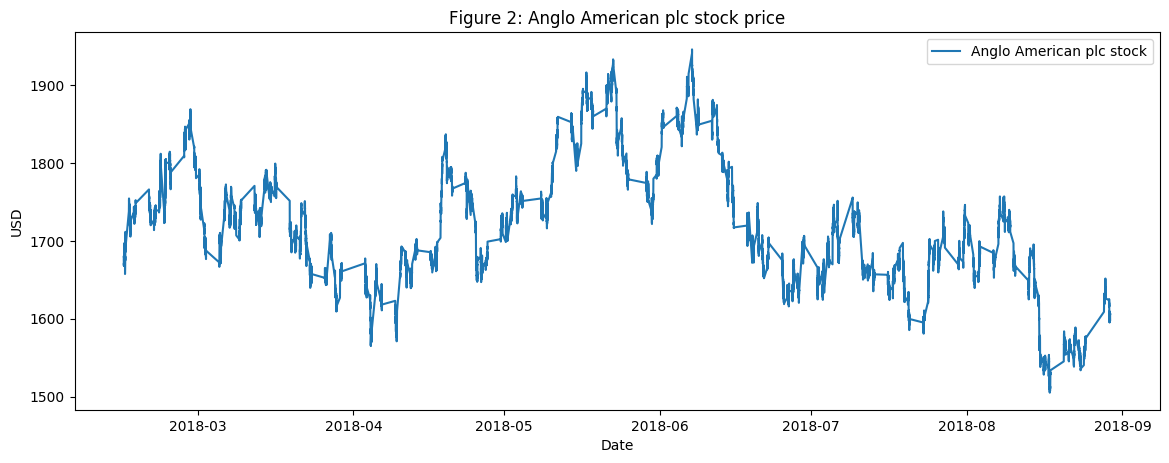

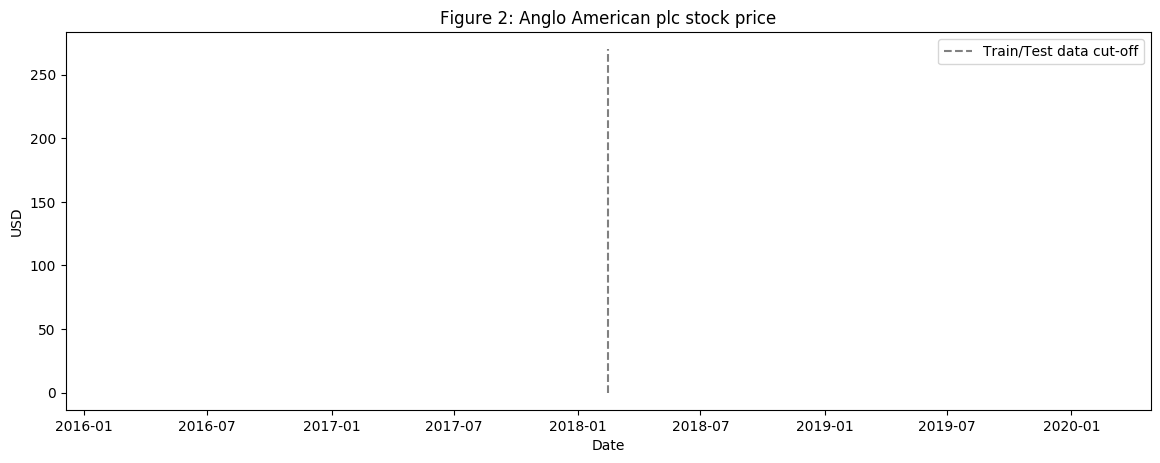

In [19]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

# Let's visualize the stock for the 7 months. The dashed vertical line represents the separation between training and test data.
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Dates'], dataset_ex_df['Close'], label='{} stock'.format(sheets[0]))
#plt.vlines(dataset_ex_df['Dates'][0], 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[0]))
plt.legend()
plt.show()

plt.figure(figsize=(14, 5), dpi=100)
plt.vlines(dataset_ex_df['Dates'][0], 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[0]))
plt.legend()
plt.show()

In [20]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 47716. Number of test days: 20451.


# Correlated assets 

---


As explained earlier we will use other assets as features, not only Anglo-American Plc.
So what other assets would affect Anglo-American Plc stock movements? Good understanding of the company, its lines of businesses, competitive landscape, dependencies, suppliers and client type, etc is very important for picking the right set of correlated assets:

First are the companies similar to Anglo-American Plc. We will see if other companies in dataset have a correlation.
As an multinational mining company based in Johannesburg, South Africa and London, United Kingdom, Anglo-American Plc depends on the global economy. Bad or volatile economy means no M&As or IPOs, and possibly limited proprietary trading earnings. That is why we will include global economy indices. Also, we will include LIBOR (USD and GBP denominated) rate, as possibly shocks in the economy might be accounted for by analysts to set these rates, and other FI securities.
Daily volatility index (VIX) - for the reason described in the previous section.
Composite indices - such NASDAQ and NYSE (from USA), FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices.
Currencies - global trade is many times reflected into how currencies move, ergo we'll use a basket of currencies (such as USDJPY, GBPUSD, etc) as features.
Overall, we have 72 other assets in the dataset - daily price for every asset.***

# Technical indicators 
We already covered what are technical indicators and why we use them so let's jump straight to the code. We will create technical indicators only for Anglo American Plc.

In [0]:
import pandas as pd
import numpy as np

In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [25]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])
dataset_TI_df

,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,1679.8,NaN,NaN,1679.800000,1679.800000,0.000000,NaN,NaN,NaN,1679.800000,1678.8
1,1680.8,NaN,NaN,1680.319231,1680.341667,0.022436,NaN,NaN,NaN,1680.550000,1679.8
2,1679.0,NaN,NaN,1679.845244,1679.818014,-0.027230,NaN,NaN,NaN,1679.476923,1678.0
3,1675.6,NaN,NaN,1678.658459,1678.486552,-0.171908,NaN,NaN,NaN,1676.860000,1674.6
4,1676.4,NaN,NaN,1678.134713,1677.919643,-0.215070,NaN,NaN,NaN,1676.552066,1675.4
...,...,...,...,...,...,...,...,...,...,...,...
68162,1604.4,1604.342857,1604.333333,1603.783668,1604.503327,0.719658,1.150561,1606.634454,1602.032212,1604.667837,1603.4
68163,1605.4,1604.657143,1604.523810,1603.903396,1604.641276,0.737880,1.033339,1606.590488,1602.457132,1605.155946,1604.4
68164,1606.2,1605.057143,1604.714286,1604.073515,1604.881080,0.807565,0.970946,1606.656178,1602.772393,1605.851982,1605.2
68165,1606.4,1605.342857,1604.895238,1604.245847,1605.114760,0.868913,0.987501,1606.870240,1602.920236,1606.217327,1605.4


So we have the technical indicators for every trading day. We have in total 11 technical indicators.


In [0]:
# Let's visualize the last 400 days of these indicators.
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for {} - last {} days.'.format(sheets[0],last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

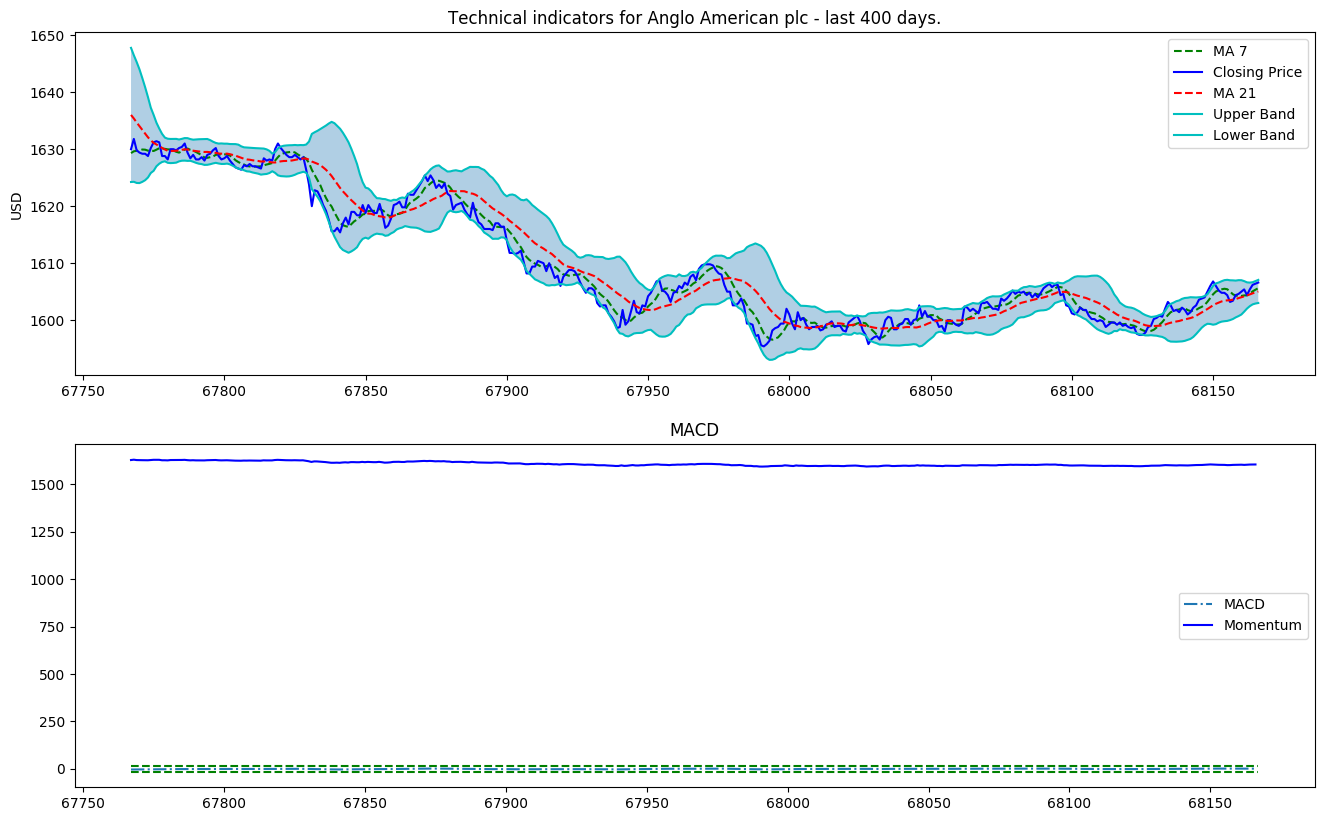

In [0]:
plot_technical_indicators(dataset_TI_df, 400)

#Fundamental analysis 
For fundamental analysis we will perform sentiment analysis on all daily news abou XXX. Using sigmoid the end result will be between 0 and 1. The closer the score is to 0 - the more negative the news is (closer to 1 indicates positive sentiment). For each day, we will create the average daily score (as a number between 0 and 1) and add it as a feature.

# Bidirectional Embedding Representations from Transformers - BERT 
For the purpose of classifying news as positive or negative (or neutral) we will use BERT, which is a pre-trained language representation.

Pretrained BERT models are already available in MXNet/Gluon. We just need to instantiated them and add two (arbitrary number) Dense layers, going to softmax - the score is from 0 to 1.

In [27]:
! pip install bert

  Created wheel for bert: filename=bert-2.2.0-cp36-none-any.whl size=3754 sha256=8e502426865bac75f3e24bf395ba989c5d3e5697fb9246e756c716d3bb06dfb5
  Stored in directory: /root/.cache/pip/wheels/fe/71/b7/941459453bd38e5d97a8c886361dee19325e9933c9cf88ad46
  Created wheel for erlastic: filename=erlastic-2.0.0-cp36-none-any.whl size=6789 sha256=930c4574bd78608a1966e868ce1b9e281ca6a35256ede58dce833978dee80f70
  Stored in directory: /root/.cache/pip/wheels/02/62/46/93c713a5f061aeeb4f16eb6bf5ee798816e6ddda70faa78e69
Successfully built bert erlastic


# Fourier transforms for trend analysis 
Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function. Mathematically speaking, the transforms look like this:

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$
We will Fourier transforms to extract global and local trends in the GS stock, and to also denoise it a little. So let's see how it works.

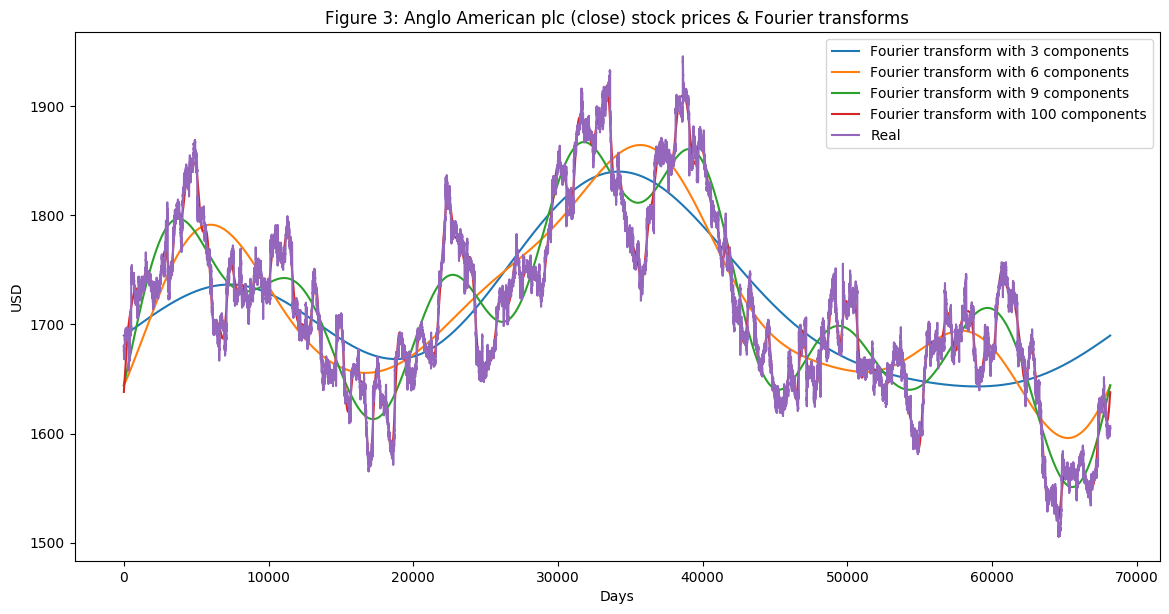

In [28]:
# import bert
import bert
data_FT = dataset_ex_df[['Dates', 'Close']]

close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: {} (close) stock prices & Fourier transforms'.format(sheets[0]))
plt.legend()
plt.show()

As you see in Figure 3 the more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap. We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

Another technique used to denoise data is call wavelets. *Wavelets* and Fourier transform gave similar results so we will only use Fourier transforms.

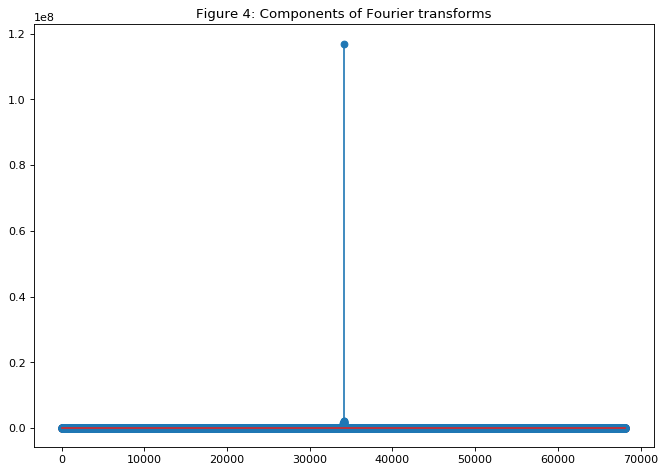

In [30]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# ARIMA as a feature
ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

In [32]:
!python3 -m pip install statsmodels

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                68166
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -132826.212
Method:                       css-mle   S.D. of innovations              1.698
Date:                Tue, 28 Jan 2020   AIC                         265666.423
Time:                        21:03:13   BIC                         265730.331
Sample:                             1   HQIC                        265686.158
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.006     -0.167      0.868      -0.014       0.012
ar.L1.D.Close    -0.0097      0.004     -2.538      0.011      -0.017      -0.002
ar.L2.D.Close     0.0115      0.004     

In [33]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

NameError: ignored

In [0]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
print(X)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

[1679.8 1680.8 1679.  ... 1606.2 1606.4 1606.6]


In [0]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on {} stock'.format(sheets[0]))
plt.legend()
plt.show()

As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Anglo American Plc as possible. We go test MSE (mean squared error) of ***, which by itself is not a bad result (considering we do have a lot of test data), but still we will only use it as a feature in the LSTM.

# Statistical checks 

---


Ensuring that the data has good quality is very important for out models. In order to make sure our data is suitable we will perform a couple of simple checks in order to ensure that the results we achieve and observe are indeed real, rather than compromised due to the fact that the underlying data distribution suffers from fundamental errors.

> **Heteroskedasticity, multicollinearity, serial correlation** 


1. Conditional Heteroskedasticity occurs when the error terms (the difference between a predicted value by a regression and the real value) are dependent on the data - for example, the error terms grow when the data point (along the x-axis) grow..
2. Multicollinearity is when error terms (also called residuals) depend on each other.
3. Serial correlation is when one data (feature) is a formula (or completely depemnds) of another featur


# FEATURE ENGINEERING

---



In [0]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has **** samples, and *** features.
So, after adding all types of data (the correlated assets, technical indicators, fundamentl analysis, Fourier, and Arima) we have a total of *** features for the ***** days (as mentioned before, however, only *** days are for training data).
We will also have some more features generated from the autoencoders.

# Feature importance with XGBoost
Having so many features we have to consider whether all of them are really indicative of the direction Anglo American Plc stock will take. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.

Since the features dataset is quite large, for the purpose of presentation here we'll use only the technical indicators. During the real features importance testing all selected features proved somewhat important so we won't exclude anything when training the GAN.

In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [0]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [0]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [0]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [0]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

Let's plot the training and validation errors in order to observe the training and check for overfitting (there isn't overfitting).

In [0]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [0]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

Not surprisingly (for those with experience in stock trading) that *****MA7, MACD, and BB** are among the important features.
We followed the same logic for performing feature importance over the whole dataset - just the training took longer and results were a little more difficult to read, as compared with just a handful of features.

# Extracting high-level features with Stacked Autoencoders 
Before we proceed to the autoencoders, we'll explore an alternative activation function.

# Activation function - GELU (Gaussian Error) 
GELU - Gaussian Error Linear Unites was recently proposed - link. In the paper the authors show several instances in which neural networks using GELU outperform networks using ReLU as an activation. gelu is also used in BERT, the NLP approach we used for news sentiment analysis. We will use GELU for the autoencoders.

In [0]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

Let's visualize GELU, ReLU, and LeakyReLU (the last one is mainly used in GANs - we also use it).

In [0]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()
plt.show()

In [0]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [0]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu
        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [0]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size)

In [0]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [0]:
print(net)

So we have *****3 layers (with 400 neurons in each) in both the encoder and the decoder.**

In [0]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""
end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

In [0]:
dataset_total_df['Dates'] = dataset_ex_df['Dates']

In [0]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)

In [0]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

We created *** *112 more features from the autoencoder. As we want to only have high level features (overall patterns) we will create an Eigen portfolio on the newly created 112 features using Principal Component Analysis (PCA). This will reduce the dimension (number of columns) of the data. The descriptive capability of the Eigen portfolio will be the same as the original 112 features.***

# Eigen portfolio with PCA

In [0]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)
x_pca = StandardScaler().fit_transform(vae_added_df)

In [0]:
principalComponents = pca.fit_transform(x_pca)

In [0]:
principalComponents.n_components_

So, in order to explain 80% of the variance we need 84 (out of the 112) features. This is still a lot. So, for now we will not include the autoencoder created features. I will work on creating the autoencoder architecture in which we get the output from an intermediate layer (not the last one) and connect it to another Dense layer with, say, 30 neurons. Thus, we will 1) only extract higher level features, and 2) come up with significantly fewer number of columns.****

# Deep Supervised Learning for anamoly detection

# Generative Adversarial Network (GAN)
Generative Adversarial Networks (GAN) have been recently used mainly in creating realistic images, paintings, and video clips. There aren't many applications of GANs being used for predicting time-series data as in our case. The main idea, however, should be same - we want to predict future stock movements. In the future, the pattern and behavior of Anglo American PlCs stock should be more or less the same (unless it starts operating in a totally different way, or the economy drastically changes). Hence, we want to 'generate' data for the future that will have similar (not absolutely the same, of course) distribution as the one we already have - the historical trading data. So, in theory, it should work.
In our case, we will use LSTM as a time-series generator, and CNN as a discriminator.

# The Generator- One layer RNN 
# 1.LSTM or GRU 
As mentioned before, the generator is a LSTM network a type of Recurrent Neural Network (RNN). RNNs are used for time-series data because because they keep track of all previous data points and can capture patterns developing through time. Due to their nature, RNNs many time suffer from vanishing gradient - that is, the changes the weights receive during training become so small, that they don't change, making the network unable to converge to a minimal loss (The opposite problem can also be observed at times - when gradients become too big. This is called gradient exploding, but the solution to this is quite simple - clip gradients if they start exceeding some constant number, i.e. gradient clipping). Two modifications tackle this problem - Gated Recurrent Unit (GRU) and Long-Short Term Memory (LSTM). The biggest differences between the two are: 1) GRU has 2 gates (update and reset) and LSTM has 4 (update, input, forget, and output), 2) LSTM maintains an internal memory state, while GRU doesn’t,
and 3) LSTM applies a nonlinearity (sigmoid) before the output gate, GRU doesn’t.

In most cases LSTM and GRU give similar results in terms of accuracy but GRU is much less computational intensive, as GRU has much fewer trainable params. LSTMs, however, and much more used.

Strictly speaking, the math behind the LSTM cell (the gates) is:

$$g_t = \text{tanh}(X_t W_{xg} + h_{t-1} W_{hg} + b_g),$$$$i_t = \sigma(X_t W_{xi} + h_{t-1} W_{hi} + b_i),$$$$f_t = \sigma(X_t W_{xf} + h_{t-1} W_{hf} + b_f),$$$$o_t = \sigma(X_t W_{xo} + h_{t-1} W_{ho} + b_o),$$$$c_t = f_t \odot c_{t-1} + i_t \odot g_t,$$$$h_t = o_t \odot \text{tanh}(c_t),$$
where $\odot$ is an element-wise multiplication operator, and, for all $x = [x_1, x_2, \ldots, x_k]^\top \in R^k$ the two activation functions:,

where $\odot$ is an element-wise multiplication operator, and, for all $x = [x_1, x_2, \ldots, x_k]^\top \in R^k$ the two activation functions:,

$$\sigma(x) = \left[\frac{1}{1+\exp(-x_1)}, \ldots, \frac{1}{1+\exp(-x_k)}]\right]^\top,$$$$\text{tanh}(x) = \left[\frac{1-\exp(-2x_1)}{1+\exp(-2x_1)},  \ldots, \frac{1-\exp(-2x_k)}{1+\exp(-2x_k)}\right]^\top$$

# 2.The LSTM architecture 
The LSTM architecture is very simple - one LSTM layer with 112 input units (as we have 112 features in the dataset) and 500 hidden units, and one Dense layer with 1 output - the price for every day. The initializer is Xavier and we will use L1 loss (which is mean absolute error loss with L1 regularization - see section 4.4.5. for more info on regularization).

Note - In the code you can see we use Adam (with learning rate of .01) as an optimizer

In [0]:
gan_num_features = dataset_total_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
            def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

We will use 500 neurons in the LSTM layer and use Xavier initialization. For regularization we'll use L1. Let's see what's inside the LSTM as printed by MXNet.

In [0]:
print(lstm_model)

As we can see, the unput of the LSTM are the 112 features (dataset_total_df.shape[1]) which then go into 500 neurons in the LSTM layer, and then transformed to a single output - the stock price value.

The logic behind the LSTM is: we take 17 (sequence_length) days of data (again, the data being the stock price for GS stock every day + all the other feature for that day - correlated assets, sentiment, etc.) and try to predict the 18th day.

In another post I will explore whether modification over the vanilla LSTM would be more beneficial, such as:

> using bidirectional LSTM layer - in theory, going backwards (from end of the data set towards the beginning) might somehow help the LSTM figure out the pattern of the stock movement.

> using stacked RNN architecture - having not only one LSTM layer but 2 or more. This, however, might be dangerous, as we might end up overfitting the model, as we don't have a lot of data (we have just 1,585 day worth of data).

> Exploring GRU - as already explained, GRUs' cells are much more simpler.

> Adding attention vectors to the RNN.

# 3. Learning rate scheduler 
One of the most important hyperparameters is the learning rate. Setting the learning rate for almost every optimizer (such as SGD, Adam, or RMSProp) is crucially important when training neural networks because it controls both the speed of convergence and the ultimate performance of the network. One of the simplest learning rate strategies is to have a fixed learning rate throughout the training process. Choosing a small learning rate allows the optimizer find good solutions, but this comes at the expense of limiting the initial speed of convergence. Changing the learning rate over time can overcome this tradeoff.

In [0]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle
        class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx
      

In [0]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

# How to prevent overfitting and the bias-variance trade-off 
Having a lot of features and neural networks we need to make sure we prevent overfitting and be mindful of the total loss.

We use several techniques for preventing overfitting (not only in the LSTM, but also in the CNN and the auto-encoders):

> Ensuring data quality. We already performed statistical checks and made sure the data doesn't suffer from multicollinearity or serial autocorrelation. Further we performed feature importance check on each feature. Finally, the initial feature selection (e.g. selecting correlated assets, technical indicators, etc.) was done with some domain knowledge about the mechanics behind the way stock markets work.

> Regularization (or weights penalty). The two most widely used regularization techniques are  (L1) and Ridge (L2). L1 adds the mean absolute error and L2 adds mean squared error to the loss. Without going into too many mathematical details, the basic differences are: lasso regression (L1) does both variable selection and parameter shrinkage, whereas Ridge regression only does parameter shrinkage and end up including all the coefficients in the model. In presence of correlated variables, ridge regression might be the preferred choice. Also, ridge regression works best in situations where the least square estimates have higher variance. Therefore, it depends on our model objective. The impact of the two types of regularizations is quite different. While they both penalize large weights, L1 regularization leads to a non-differentiable function at zero. L2 regularization favors smaller weights, but L1 regularization favors weights that go to zero. So, with L1 regularization you can end up with a sparse model - one with fewer parameters. In both cases the parameters of the L1 and L2 regularized models "shrink", but in the case of L1 regularization the shrinkage directly impacts the complexity (the number of parameters) of the model. Precisely, ridge regression works best in situations where the least square estimates have higher variance. L1 is more robust to outliers, is used when data is sparse, and creates feature importance. We will use L1.

> Dropout. Dropout layers randomly remove nodes in the hidden layers.

> Dense-sparse-dense training

> Early stopping : Another important consideration when building complex neural networks is the bias-variance trade-off. Basically, the error we get when training nets is a function of the bias, the variance, and irreducible error - σ (error due to noise and randomness). The simplest formula of the trade-off is:

$$Error = bias^{2} + variance + \sigma$$

> Bias. Bias measures how well a trained (on training dataset) algorithm can generalize on unseen data. High bias (underfitting) meaning the model cannot work well on unseen data.

> Variance. Variance measures the sensitivity of the model to changes in the dataset. High variance is the overfitting.


# The Discriminator - One Dimentional CNN 
# 4. Why CNN as a discriminator? 
We usually use CNNs for work related to images (classification, context extraction, etc). They are very powerful at extracting features from features from features, etc. For example, in an image of a dog, the first convolutional layer will detect edges, the second will start detecting circles, and the third will detect a nose. In our case, data points form small trends, small trends form bigger, trends in turn form patterns. CNNs' ability to detect features can be used for extracting information about patterns in GS's stock price movements.

Another reason for using CNN is that CNNs work well on spatial data - meaning data points that are closer to each other are more related to each other, than data points spread across. This should hold true for time series data. In our case each data point (for each feature) is for each consecutive day. It is natural to assume that the closer two days are to each other, the more related they are to each other. One thing to consider (although not covered in this work) is seasonality and how it might change (if at all) the work of the CNN.

# The CNN Architecture 
Figure 11: High level overview of the CNN architecture.

The code for the CNN inside the GAN looks like this

In [0]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))
    
# ... other parts of the GAN

In [0]:
print(cnn_net)